PAC. Pràctica 2. Tipologia i cicle de vida de les dades. Universitat Oberta de Catalunya.

J. de Curtò i DíAz & I. de Zarzà i Cubero. decurto@uoc.edu dezarza@uoc.edu

t-SNE and PCA (components selected to explain 99% of variance) with images from Curiosity.

Adapt folder paths accordingly. Data is available at:

CyZ: MARS Space Exploration Dataset.

https://github.com/decurtoidiaz/cyz

DrCyZ: Techniques for analyzing and extracting useful information from CyZ.

https://github.com/decurtoidiaz/drcyz

c@decurto.be z@dezarza.be

Original source code from:

https://colab.research.google.com/github/dvschultz/ml-art-colabs/blob/master/Stylegan2_ada_Custom_Training.ipynb

adapted and modified by De Curtò i DíAz & De Zarzà i Cubero.

### Parse all images in custom folder, saves their color and path into the data array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.feature_extraction import image
from skimage import io
from sklearn.manifold import TSNE

!unzip '/content/drive/MyDrive/Colab Notebooks/cyz_1.1.zip'

data = []
folder = '/content/cyz_1.1/curiosity_cyz/png/'

for filename in os.listdir(folder):
    image = cv2.imread(os.path.join(folder,filename))
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (64,64))
        image = image.flatten()
        data.append([image, folder + filename])


In [ ]:
print(len(data))
features, images  = zip(*data)

41425


### Training part

Instantiate a PCA object, which we will then fit our data to, choosing the adequate number of principal components to explain the 99% of variance. This may take a few minutes.

In [ ]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=0.99, svd_solver='full')
pca.fit(features)
pca_features = pca.transform(features)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())
print(pca.n_components_)

[3.32881889e+06 1.68059055e+06 1.08131421e+06 ... 1.01072405e+02
 1.01004857e+02 1.00862950e+02]
[3.33581389e-01 1.68412206e-01 1.08358643e-01 ... 1.01284794e-05
 1.01217103e-05 1.01074898e-05]
[0.33358139 0.5019936  0.61035224 ... 0.98998276 0.98999289 0.99000299]
1919


In [ ]:
num_images_to_plot = 41425

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [ ]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Indexed 41425 samples in 0.072s...
[t-SNE] Computed neighbors for 41425 samples in 196.850s...
[t-SNE] Computed conditional probabilities for sample 1000 / 41425
[t-SNE] Computed conditional probabilities for sample 2000 / 41425
[t-SNE] Computed conditional probabilities for sample 3000 / 41425
[t-SNE] Computed conditional probabilities for sample 4000 / 41425
[t-SNE] Computed conditional probabilities for sample 5000 / 41425
[t-SNE] Computed conditional probabilities for sample 6000 / 41425
[t-SNE] Computed conditional probabilities for sample 7000 / 41425
[t-SNE] Computed conditional probabilities for sample 8000 / 41425
[t-SNE] Computed conditional probabilities for sample 9000 / 41425
[t-SNE] Computed conditional probabilities for sample 10000 / 41425
[t-SNE] Computed conditional probabilities for sample 11000 / 41425
[t-SNE] Computed conditional probabilities for sample 12000 / 41425
[t-SNE] Computed conditional probabilities for sample 13000 / 41425
[t-SNE] Computed condi

Internally, t-SNE uses an iterative approach, making small (or sometimes large) adjustments to the points. By default, t-SNE will go a maximum of 1000 iterations, but in practice, it often terminates early because it has found a locally optimal (good enough) embedding.

The variable tsne contains an array of unnormalized 2d points, corresponding to the embedding. In the next cell, we normalize the embedding so that lies entirely in the range (0,1).

In [ ]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

### Plots the clusters

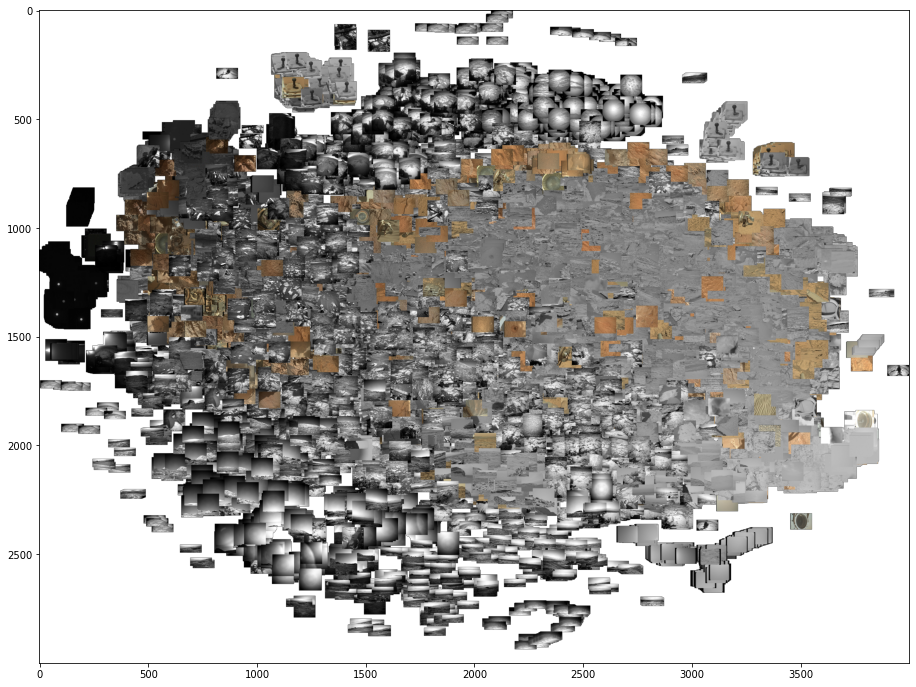

In [ ]:
import matplotlib.pyplot
from matplotlib.pyplot import imshow

width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

### Save a json and a png of the cluster

In [ ]:
import os
import json

full_image.save("/content/drive/MyDrive/Colab Notebooks/test_ac99_tsne_curiosity_cyz+.png")

tsne_path = "/content/drive/MyDrive/Colab Notebooks/test_ac99_tsne_curiosity_cyz+.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)


saved t-SNE result to /content/drive/MyDrive/Colab Notebooks/test_ac99_tsne_curiosity_cyz+.json


### Paste into grid

In [ ]:
!pip install rasterfairy-py3
import rasterfairy
nx = 70
ny = 72

grid_assignment = rasterfairy.transformPointCloud2D(tsne)

no good rectangle found for 41425 points, using incomplete square 203 * 205


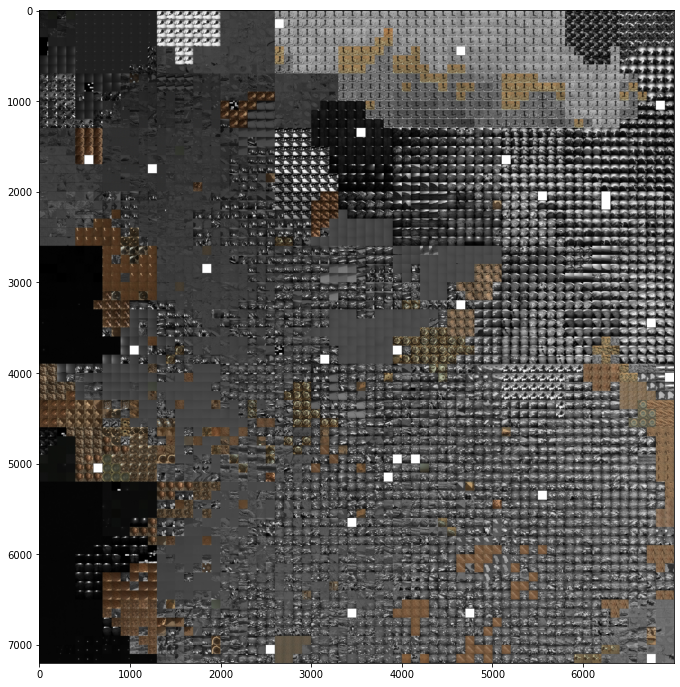

In [ ]:
tile_width = 100
tile_height = 100

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGBA', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)

In [ ]:
background = Image.new("RGB", grid_image.size, (255, 255, 255))
background.paste(grid_image, mask=grid_image.split()[3]) # 3 is the alpha channel

background.save('/content/drive/MyDrive/Colab Notebooks/grid-ac99tsne_curiosity_cyz+.png', 'PNG', quality=100)